Loading data from cache: comprehensive_analysis_data.pkl

[分析①] 最新データに基づく優良・注意銘柄のパフォーマンス


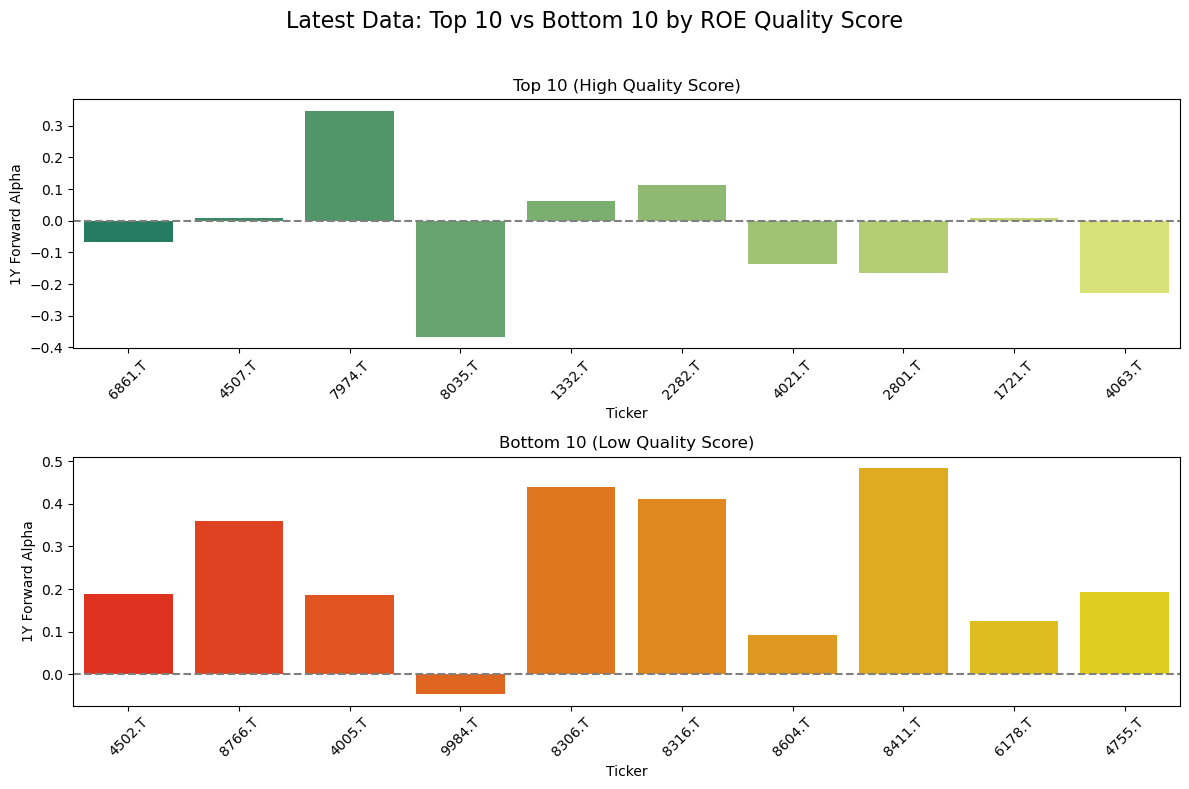


[分析②] 企業内時系列比較（ヒット率分析）

ROEクオリティスコアが改善した企業数: 33社
そのうち、超過リターンも改善した企業数（ヒット数）: 20社
ヒット率: 60.61%


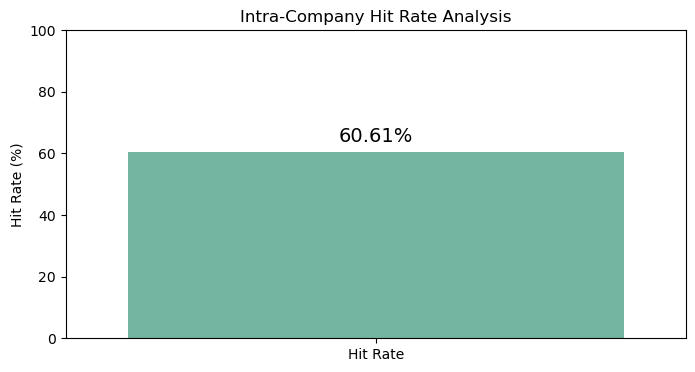


--- 分析（プールデータ分析）---

[分析1] ROE Quality Score vs. Future Returns


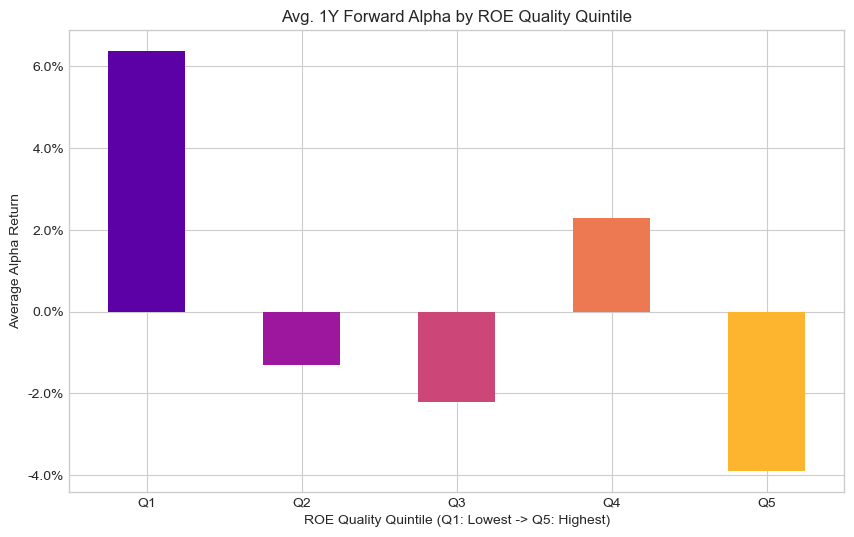


[分析2] ROE vs. Quality Matrix Analysis


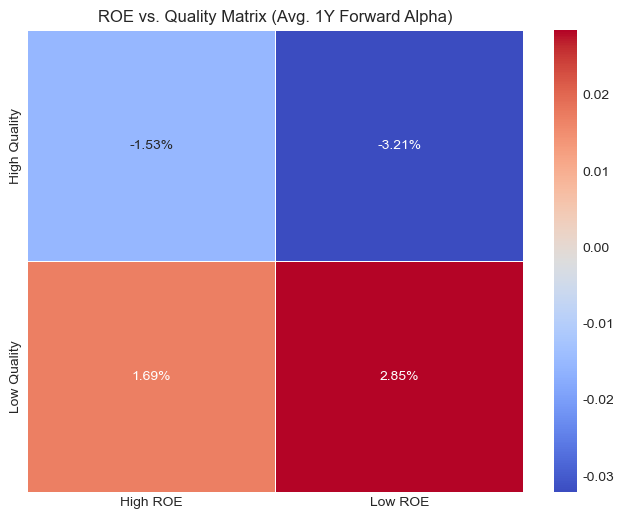

In [1]:
# 分析全体を統括するメインスクリプト
import os
import pandas as pd
import time
from warnings import filterwarnings

# 自作モジュールをインポート
import config
import data_fetcher
import factor_engine
import visualizer

# 警告を非表示
filterwarnings('ignore', category=FutureWarning)

def main():
    """メインの実行関数"""
    # キャッシュが存在すれば読み込む
    if os.path.exists(config.CACHE_FILE_PATH):
        print(f"Loading data from cache: {config.CACHE_FILE_PATH}")
        final_data = pd.read_pickle(config.CACHE_FILE_PATH)
    else:
        # --- データ取得 ---
        price_data, benchmark_prices = data_fetcher.fetch_all_price_data(
            config.NIKKEI_TICKERS, config.BENCHMARK_TICKER
        )
        
        all_results = []
        for ticker_code in config.NIKKEI_TICKERS:
            time.sleep(0.5) # API負荷軽減
            
            # 個別銘柄の財務データを取得
            financials, balance_sheet, info = data_fetcher.fetch_financials_for_ticker(ticker_code)
            if financials is None:
                continue
            
            # 個別銘柄の株価データを抽出
            hist_prices_single = price_data[price_data['Ticker'] == ticker_code]

            # --- ファクター計算 ---
            base_factors = factor_engine.calculate_base_factors(
                ticker_code, financials, balance_sheet
            )
            if base_factors is None:
                continue
                
            returns_df = factor_engine.calculate_forward_returns(base_factors, hist_prices_single)
            all_results.append(returns_df)

        if not all_results:
            print("No data could be processed.")
            return

        # --- 全データの結合と追加計算 ---
        combined_df = pd.concat(all_results)
        combined_df.dropna(inplace=True)
        
        combined_df = factor_engine.calculate_forward_alphas(combined_df, benchmark_prices)
        combined_df = factor_engine.calculate_roe_quality_score(combined_df)
        
        cols_to_convert = [
            'ROE', 'ProfitMargin', 'AssetTurnover', 'FinancialLeverage',
            'ROE_Quality_Score',
            'Fwd_3M_Alpha', 'Fwd_6M_Alpha', 'Fwd_1Y_Alpha'
        ]
        for col in cols_to_convert:
            if col in combined_df.columns:
                combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        combined_df.dropna(inplace=True)
        
        combined_df.to_pickle(config.CACHE_FILE_PATH)
        print(f"Data cached to {config.CACHE_FILE_PATH}")
        final_data = combined_df

    # --- 可視化 ---
    if final_data is not None and not final_data.empty:
        visualizer.run_new_analyses(final_data)
        visualizer.run_pooled_data_analysis(final_data)
    else:
        print("No data to visualize.")

if __name__ == "__main__":
    main()